In [ ]:
# dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("archive/Tweets.csv")
df = df.rename(columns={"airline_sentiment":"label","text":"text"})
df = df[["label","text"]].dropna()
df = df[df["text"].str.strip().ne("")]
print(df.shape)
print(df["label"].value_counts())
df.head(5)

(14640, 2)
label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)
df[["text","clean_text"]].head(5)

[nltk_data] Downloading package punkt to /Users/zhirdana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zhirdana/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhirdana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zhirdana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhirdana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer(max_features=5000)
X_bow = count_vectorizer.fit_transform(df["clean_text"])

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])

y = df["label"]
print("Bag-of-Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)
y.value_counts()

Bag-of-Words shape: (14640, 5000)
TF-IDF shape: (14640, 5000)


label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tfidf, X_test_tfidf, _, _ = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

logreg_bow = LogisticRegression(max_iter=200)
logreg_bow.fit(X_train_bow, y_train)
y_pred_bow = logreg_bow.predict(X_test_bow)

logreg_tfidf = LogisticRegression(max_iter=200)
logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print("Bag-of-Words Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Bag-of-Words Accuracy: 0.7790300546448088
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      1835
     neutral       0.60      0.61      0.60       620
    positive       0.76      0.61      0.68       473

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928

TF-IDF Accuracy: 0.7810792349726776
              precision    recall  f1-score   support

    negative       0.80      0.94      0.87      1835
     neutral       0.66      0.48      0.56       620
    positive       0.82      0.55      0.66       473

    accuracy                           0.78      2928
   macro avg       0.76      0.66      0.69      2928
weighted avg       0.77      0.78      0.77      2928



In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

models = {
    "Naive Bayes (BoW)": MultinomialNB(),
    "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Random Forest (BoW)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Random Forest (TF-IDF)": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (BoW)": LinearSVC(random_state=42),
    "SVM (TF-IDF)": LinearSVC(random_state=42)
}

results = {}

for name, model in models.items():
    if "BoW" in name:
        model.fit(X_train_bow, y_train)
        preds = model.predict(X_test_bow)
    else:
        model.fit(X_train_tfidf, y_train)
        preds = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Naive Bayes (BoW) Accuracy: 0.7582
Naive Bayes (TF-IDF) Accuracy: 0.7292
Random Forest (BoW) Accuracy: 0.7705
Random Forest (TF-IDF) Accuracy: 0.7616
SVM (BoW) Accuracy: 0.7609
SVM (TF-IDF) Accuracy: 0.7807


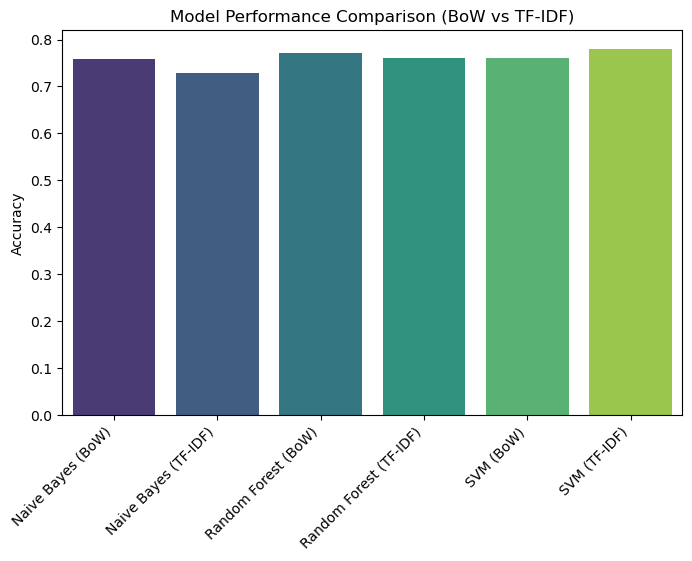

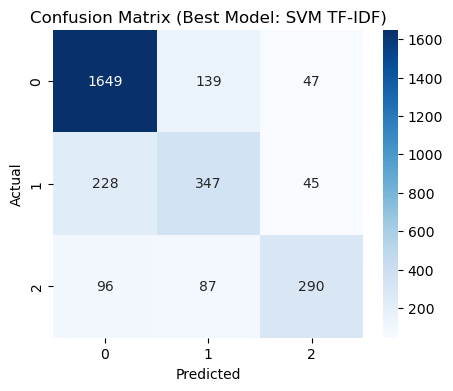

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison (BoW vs TF-IDF)")
plt.show()

best_model = LinearSVC(random_state=42)
best_model.fit(X_train_tfidf, y_train)
best_preds = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Best Model: SVM TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

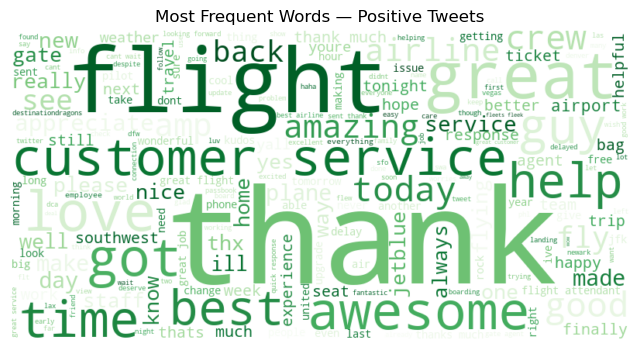

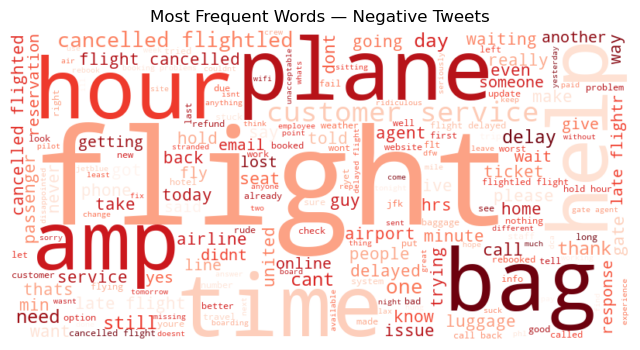

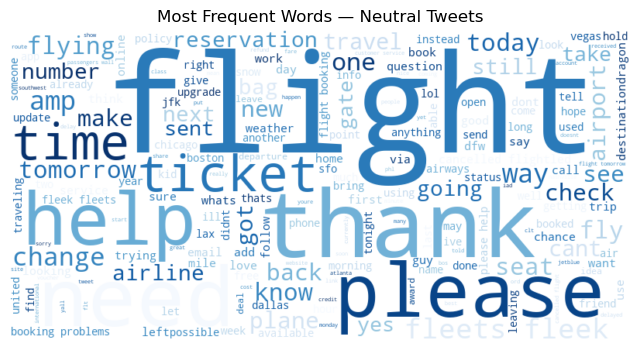

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(df[df["label"]=="positive"]["clean_text"])
wordcloud_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words — Positive Tweets")
plt.show()

negative_text = " ".join(df[df["label"]=="negative"]["clean_text"])
wordcloud_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words — Negative Tweets")
plt.show()

neutral_text = " ".join(df[df["label"]=="neutral"]["clean_text"])
wordcloud_neu = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(neutral_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_neu, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words — Neutral Tweets")
plt.show()

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["label"])
print(encoder.classes_)

['negative' 'neutral' 'positive']


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["clean_text"]
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

              precision    recall  f1-score   support

    negative       0.80      0.94      0.86      1835
     neutral       0.66      0.47      0.55       620
    positive       0.82      0.57      0.67       473

    accuracy                           0.78      2928
   macro avg       0.76      0.66      0.69      2928
weighted avg       0.77      0.78      0.77      2928



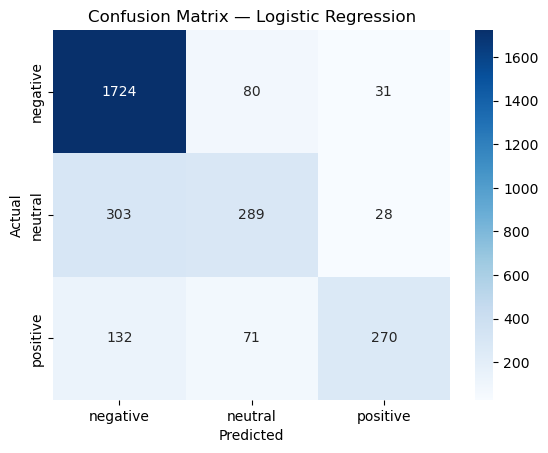

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = LogisticRegression(max_iter=200)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()